# Benchmark inference speed: RecTools wrapper for LightFM

Comparing speed of inference: RecTools LightFM wrapper vs original LightFM framework. Inference on Movielens 20-m dataset

Real speed may vary depending on actual hardware and library versions

LightFM library is required to run this notebook. You can install it with `pip install rectools[lightfm]`

In [2]:
import rectools
import lightfm
print(rectools.__version__)
print(lightfm.__version__)

0.4.0
1.17


In [ ]:
import os
import warnings
import time

from pathlib import Path
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import LightFMWrapperModel

from lightfm import LightFM

os.environ["OPENBLAS_NUM_THREADS"] = "1"
sns.set_theme(style="whitegrid")

## Load data: Movielens 20m

In [3]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-20m.zip -O ml-20m.zip
!unzip -o ml-20m.zip
!rm ml-20m.zip

Archive:  ml-20m.zip
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         
CPU times: user 266 ms, sys: 105 ms, total: 371 ms
Wall time: 32.5 s


In [4]:
ratings = pd.read_csv(
    "ml-20m/ratings.csv",
    header=0,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
)
print(ratings.shape)
ratings.head()

(20000263, 4)


,user_id,item_id,weight,datetime
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


## Train LightFM model with different latent factors dimension size

In [5]:
def make_base_model(factors: int):
    return LightFMWrapperModel(LightFM(no_components=factors, loss="bpr"))

dataset = Dataset.construct(ratings)

fitted_models = {}

factors = list(range(64, 257, 64))
for n_factors in factors:
    model = make_base_model(n_factors)
    model.fit(dataset)
    fitted_models[n_factors] = model

## Compute inference speed for both frameworks on all models

In [6]:
# we will use 8 threads for both RecTools and LightFM inference
# we will run each experiment 10 times to get mean values
NUM_THREADS = 8
K_RECOS = 10
NUM_REPEATS = 10

In [7]:
# prepare external (real) movielens user ids for RecTools inference
train_users = dataset.user_id_map.external_ids

# prepare internal sparse matrix user and items ids for LightFM inference
user_ids = dataset.user_id_map.internal_ids
item_ids = dataset.item_id_map.internal_ids
n_users = len(user_ids)
n_items = len(item_ids)

assert len(train_users) == len(user_ids)
print(len(train_users))

138493


In [8]:
def benchmark_rectools(models, n_users):
    results = []
    users = train_users[:n_users]
    for run in range(NUM_REPEATS):
        for n_factors, model in models.items():
            start = time.time()
            
            # RecTools inference. It is processed by batches of users internally
            model.n_threads = NUM_THREADS
            recos = model.recommend(
                users=users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=False,
                add_rank_col=False
            )
            
            elapsed = time.time() - start
            results.append({"factors": n_factors, "framework": "rectools", "inference_speed": elapsed, "run": run})
    return results

In [9]:
def benchmark_lightfm_batch(models, n_users, batch_size = 1000):
    results = []
    users = user_ids[:n_users]
    for run in range(NUM_REPEATS):
        for n_factors, model in models.items():
            # get LightFM framework model from RecTools wrapper
            lightfm_model = model.model
            start = time.time()

            # LightFM inference. We proceed it by batches to avoid memory problems
            reco_by_batch = []
            n_batches = n_users // batch_size 
            if n_users % batch_size > 0:
                n_batches += 1
            for i_batch in range(n_batches):
                batch_users_ids = users[i_batch * batch_size : (i_batch + 1) * batch_size]
                batch_scores = lightfm_model.predict(
                    user_ids = np.repeat(batch_users_ids, n_items),
                    item_ids = np.tile(item_ids, len(batch_users_ids)),
                    num_threads = NUM_THREADS
                ).reshape(len(batch_users_ids), n_items)            
                # scores are not sorted so we need to sort them and get top K_RECOS items for each user
                batch_unsorted_reco_positions = batch_scores.argpartition(-K_RECOS, axis=1)[:, -K_RECOS:]
                batch_unsorted_reco_scores = np.take_along_axis(batch_scores, batch_unsorted_reco_positions, axis=1)
                batch_recs = np.take_along_axis(
                        batch_unsorted_reco_positions, batch_unsorted_reco_scores.argsort()[:, ::-1], axis=1
                    )
                reco_by_batch.append(batch_recs)
            reco_by_batch = np.vstack(reco_by_batch)

            elapsed = time.time() - start
            results.append({"factors": n_factors, "framework": "lightfm", "inference_speed": elapsed, "run": run})
    return results

## Benchmark frameworks

Be careful when running this code. Inference with all the repeats and settings for all 140k train users takes a lot of time. 

We advice to select about 10k users for comparison on regular hardware and skip full comparison

In [10]:
# inference for 10k users on Movielens-20m

N_USERS = 10000
print(f"Num users for inference: {N_USERS}")
rectools_results_ten_k = benchmark_rectools(fitted_models, n_users=N_USERS)
lightfm_results_batch_ten_k = benchmark_lightfm_batch(fitted_models, n_users=N_USERS)
results_ten_k = pd.DataFrame(lightfm_results_batch_ten_k + rectools_results_ten_k)

Num users for inference: 10000


In [11]:
# inference for all train users on Movielens-20m

print(f"Num users for inference: {n_users}")
rectools_results = benchmark_rectools(fitted_models, n_users=n_users)
lightfm_results_batch = benchmark_lightfm_batch(fitted_models, n_users=n_users)
results_all = pd.DataFrame(lightfm_results_batch + rectools_results)

Num users for inference: 138493


In [12]:
results_all.head()

,factors,framework,inference_speed,run
0,64,lightfm,135.769374,0
1,128,lightfm,160.676028,0
2,192,lightfm,190.658902,0
3,256,lightfm,204.438340,0
4,64,lightfm,134.842623,1


## Compare the difference

### Inference speed
- RecTools wrapper has 5 to 25 times faster inference then original LightFM framework on the same number of threads
- RecTools wrapper doesn't increase inference speed much based on number of factors

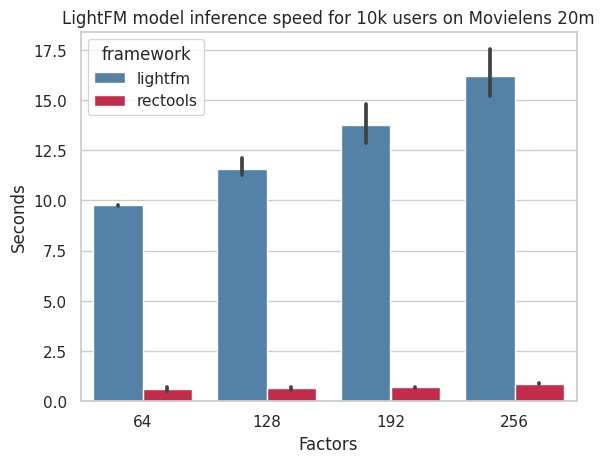

In [13]:
# Comparison on 10k users
sns.barplot(data=results_ten_k, x="factors", y="inference_speed", hue="framework", palette=["steelblue", "crimson"]);
plt.xlabel('Factors')
plt.ylabel('Seconds')
plt.title("LightFM model inference speed for 10k users on Movielens 20m")
plt.show()

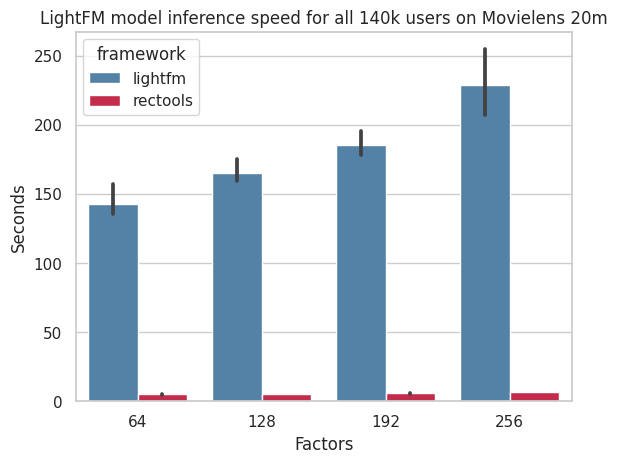

In [14]:
# Comparison on 140k users
sns.barplot(data=results_all, x="factors", y="inference_speed", hue="framework", palette=["steelblue", "crimson"]);
plt.xlabel('Factors')
plt.ylabel('Seconds')
plt.title("LightFM model inference speed for all 140k users on Movielens 20m")
plt.show()

### Other benefits of RecTools wrapper
- No need for manual construction of sparse matrixes over interactions and users/items features
- No need for manual processing of retrived scores and ranking
- Model has the same interface with all other RecTools models and can be compared easily
- `filter_viewed` and `items_to_recommend` options

### How is the speed optimized?
We are using vectorization of LightFM user/item feature factors and biases (which already provided x2 speed boost to the original library). For even faster inference we use implicit library optimized matrix_factorization top_k method over the constructed vectors.